In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import bimodal_data, plot_scatter
import matplotlib.pyplot as plt
import numpy as np

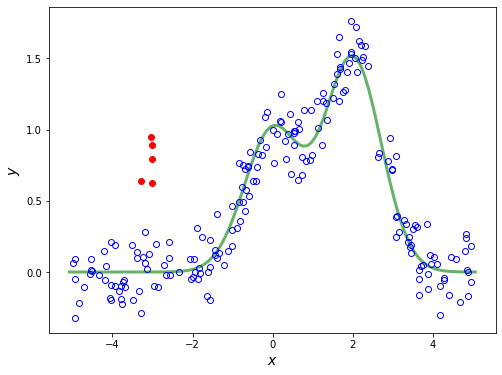

In [3]:
X_train, y_train, X_test, y_test, f_truth, outliers = bimodal_data(300, has_outlier=True)
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plt.show()

In [4]:
X_train_ol = np.r_[X_train, outliers[:, 0].reshape(-1, 1)]
y_train_ol = np.r_[y_train, outliers[:, 1]]

## 回归树

In [5]:
from pylib.utils.functions_for_regression import plot_fitted_line
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

In [6]:
tree = DecisionTreeRegressor(max_depth=2, random_state=42)
tree.fit(X_train_ol, y_train_ol)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [7]:
y_pred = tree.predict(X_train_ol)
train_err = mean_squared_error(y_train_ol, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.071


In [8]:
y_pred = tree.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.065


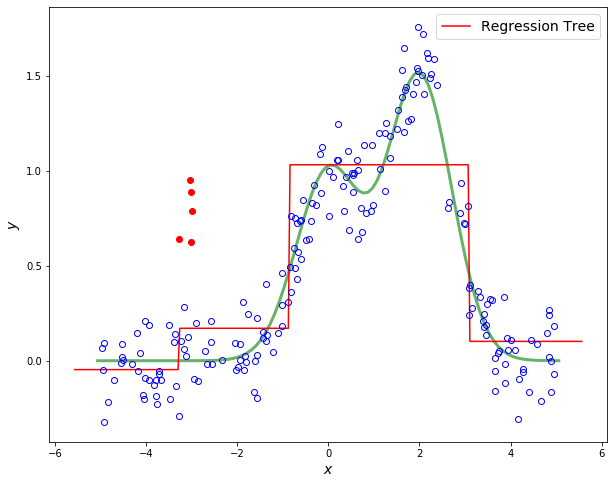

In [9]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plot_fitted_line(tree, "Regression Tree")
plt.show()

### 查看叶子节点与子区域的对应关系

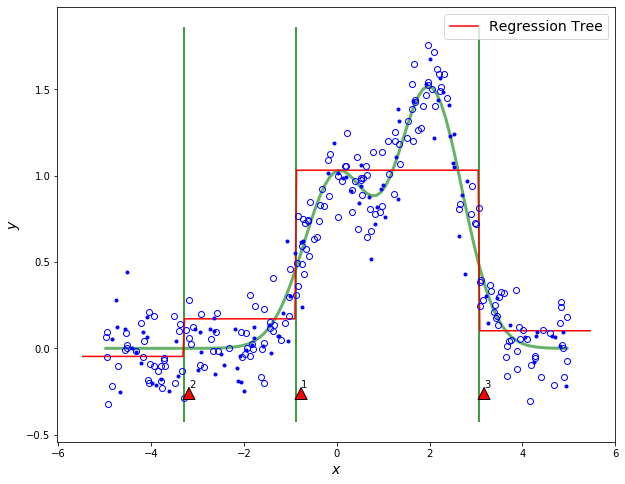

In [10]:
feature_path = tree.tree_.feature
thresholds = tree.tree_.threshold
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(tree, "Regression Tree")
plt_xmin = plt.xlim()[0]
plt_xmax = plt.xlim()[1]
plt_ymin = plt.ylim()[0]
plt_ymax = plt.ylim()[1]
split = 0
for i, f in enumerate(feature_path):
    if  f == 1:
        split += 1
        plt.hlines(thresholds[i], plt_xmin, plt_xmax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(plt_xmin + 0.1, thresholds[i] + 0.2),
                     arrowprops=dict(facecolor='red')
            )
    elif f == 0:
        split += 1
        plt.vlines(thresholds[i], plt_ymin, plt_ymax, color='g')
        plt.annotate('{}'.format(split), 
                     xy=(thresholds[i] + 0.1, plt_ymin + 0.2),
                     arrowprops=dict(facecolor='red'))
    else:
        continue
plt.show()

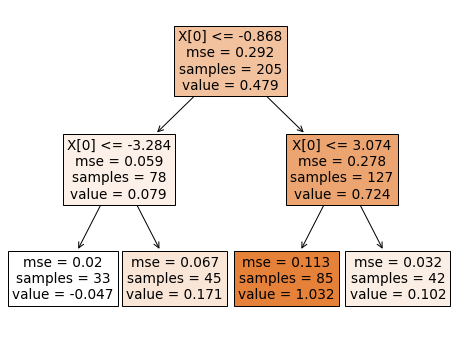

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_tree(tree, filled=True, ax=ax)
plt.show()

### 寻找最优参数

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {'max_depth': [3, 5, 7, 10, 20],
              'min_samples_leaf': np.arange(1, 20)}
tree_cv = GridSearchCV(DecisionTreeRegressor(criterion='mae', random_state=42), 
                       param_grid,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       n_jobs=-1)
tree_cv.fit(X_train_ol, y_train_ol)

E:\a-soft\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mae', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 20],
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dis

In [14]:
tree_cv.best_params_

{'max_depth': 10, 'min_samples_leaf': 3}

### 使用最优参数模型

In [15]:
tree_best = tree_cv.best_estimator_

In [16]:
y_pred = tree_best.predict(X_train_ol)
train_err = mean_squared_error(y_train_ol, y_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.014


In [17]:
y_pred = tree_best.predict(X_test)
test_err = mean_squared_error(y_test, y_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.047


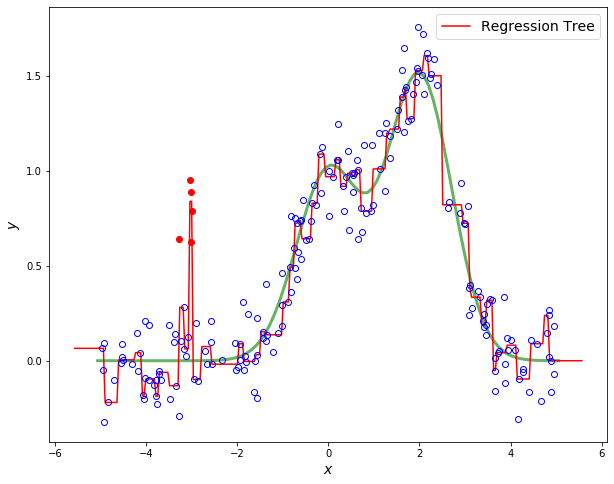

In [18]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plot_fitted_line(tree_best, "Regression Tree")
plt.show()

### 查看最优树的结构

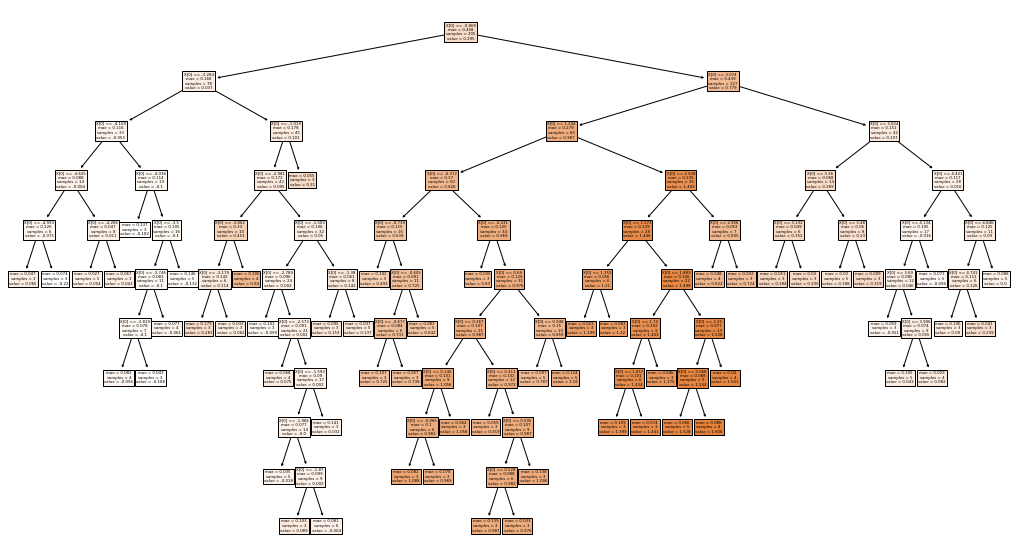

In [19]:
fig, ax = plt.subplots(figsize=(18, 10))
plot_tree(tree_best, filled=True, ax=ax,)
plt.show()